In [27]:
import torch, torchvision
from torch import nn 
from torch import optim 
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import copy

In [12]:
numb_batch=64


In [15]:
T=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data=torchvision.datasets.MNIST("mnist_data", train=True,download=True,transform =T)
val_data=torchvision.datasets.MNIST('mnist_data',train=False,download=True,transform=T)

train_dl=torch.utils.data.DataLoader(train_data,batch_size=numb_batch)
val_dl=torch.utils.data.DataLoader(val_data,batch_size=numb_batch)

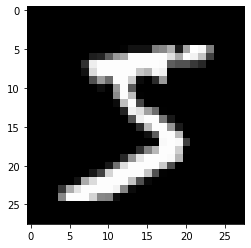

In [16]:
plt.imshow(train_data[0][0][0], cmap='gray')

In [17]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

In [24]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cpu()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [19]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")

No Cuda Available


Saving Best Model with Accuracy:  95.22000122070312
Epoch: 1 Accuracy : 95.22000122070312 %
Saving Best Model with Accuracy:  96.7699966430664
Epoch: 2 Accuracy : 96.7699966430664 %
Saving Best Model with Accuracy:  97.56999969482422
Epoch: 3 Accuracy : 97.56999969482422 %
Saving Best Model with Accuracy:  98.11000061035156
Epoch: 4 Accuracy : 98.11000061035156 %
Saving Best Model with Accuracy:  98.36000061035156
Epoch: 5 Accuracy : 98.36000061035156 %
Saving Best Model with Accuracy:  98.63999938964844
Epoch: 6 Accuracy : 98.63999938964844 %
Saving Best Model with Accuracy:  98.75
Epoch: 7 Accuracy : 98.75 %
Epoch: 8 Accuracy : 98.66999816894531 %
Saving Best Model with Accuracy:  98.80000305175781
Epoch: 9 Accuracy : 98.80000305175781 %
Saving Best Model with Accuracy:  98.8499984741211
Epoch: 10 Accuracy : 98.8499984741211 %
Saving Best Model with Accuracy:  98.95999908447266
Epoch: 11 Accuracy : 98.95999908447266 %
Epoch: 12 Accuracy : 98.55999755859375 %
Saving Best Model with Ac

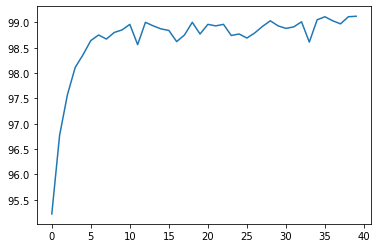

In [28]:
lenet = train(40)

In [32]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cpu()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [33]:
y_pred, y_true = predict_dl(lenet, val_dl)

In [35]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,978,0,0,0,0,0,0,0,1,1
1,0,1133,0,0,0,0,0,0,1,1
2,1,1,1026,0,0,0,1,3,0,0
3,1,0,2,998,0,3,0,2,3,1
4,0,0,0,0,977,0,2,0,0,3
5,2,0,0,2,0,886,2,0,0,0
6,4,5,0,0,1,3,943,0,2,0
7,1,2,3,0,0,0,0,1020,1,1
8,1,0,5,3,0,1,0,2,960,2
9,1,2,0,0,7,4,0,2,2,991


In [36]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

In [37]:
path='https://www.researchgate.net/profile/Thomas-Wiatowski/publication/287853768/figure/fig5/AS:667034937462785@1536044930131/Handwritten-digits-from-the-MNIST-data-set-5-If-f-denotes-the-image-of-the-handwritten.jpg'
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

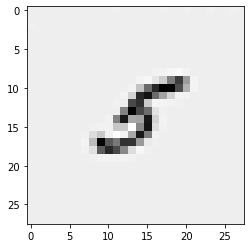

In [38]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [40]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")


Predicted: 5, Prob: 72.64904379844666 %
